# Seguro Auto - EDA & Pré-processamento
___
Uma seguradora que fornece seguro saúde para seus clientes tem interesse na construção de um modelo para prever se seus clientes do ano passado também estarão interessados no seguro auto fornecido pela empresa.

Uma apólice de seguro é um acordo pelo qual uma empresa se compromete a fornecer uma garantia de compensação por perdas, danos, doenças ou morte especificados em troca do pagamento de um prêmio especificado - uma quantia em dinheiro, que o cliente precisa pagar regularmente a uma seguradora por essa garantia.

Assim como o seguro de saúde, existe o seguro auto em que todos os anos o cliente paga um prêmio de determinado valor à seguradora para que, em caso de acidente com o veículo, a seguradora forneça uma indenização para o consumidor.

### Problema de Negócio
___

O problema de negócio consiste basicamente em prever quais clientes do ano anterior estarão interessados no seguro auto oferecido pela empresa, para que assim o time de vendas possa priorizar as pessoas com maior interesse no produto oferecido, otimizando assim a campanha voltada para os principais clientes. De acordo com [[1]](https://coverager.com/improve-customer-retention-with-the-power-of-apis/#:~:text=The%20average%20customer%20retention%20rate,success%20factors%20for%20auto%20insurers.), a retenção média de clientes para seguradoras de veículos nos EUA gira em torno de 88%.
Nesse contexto, o notebook visa realizar uma EDA dos dados para geração de insights, como também um pré-processamento visando o modelo de previsão. Dentre os insights, procura-se responder perguntas, como por exemplo:

- Quais são os atributos mais relevantes dos clientes interessados?
- Os clientes já assegurados têm tendência de permanecer ou cancelam o seguro (churn)?
- Alguma região apresenta mais clientes assegurados ou maior tendência de saída?
- Clientes mais velhos são mais interessados?
- Existe grande diferença entre clientes do gênero masculino e feminino?

### Os dados
___
O [dataset](https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction) apresenta dados de treinamento para um modelo de previsão de seguros auto, com 381109 instâncias e 11 variáveis, dentre as quais:
- `id` $\to$ id único do cliente
- `Gender`$\to$ gênero do cliente
- `Age` $\to$ idade do cliente
- `Driving_License` $\to$ se o cliente possui (1) ou não (0) habilitação
- `Region_Code` $\to$ código único da região do cliente
- `Previously_Insured`$\to$ cliente possui (1) ou não (0) seguro
- `Vehicle_Age` $\to$ idade do veículo
- `Vehicle_Damage`$\to$ veículo danificado (1) ou não (0) no passado
- `Annual_Premium` $\to$ montante pago pelo cliente à seguradora
- `Policy_Sales_Channel`$\to$ canal de atendimento ao cliente
- `Vintage`$\to$ número de dias como cliente
- `Response`$\to$ cliente interessado (1) ou não (0) no seguro

- Importar bibliotecas:

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wn

wn.filterwarnings('ignore')

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('train.csv', index_col='id')

In [3]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
df.shape

(381109, 11)

In [5]:
# from pandas_profiling import ProfileReport

# report = ProfileReport(df)

# report

- Análise das variáveis:
    - `Gender`$\to$ var. qualitativa binária com 54% de homens 
    - `Age` $\to$ var. quantitativa discreta com 66 valores distintos com assimetria à direita - maioria dos clientes são jovens, com idade máxima de 85 anos
    - `Driving_License` $\to$ var. qualitativa binária extremamente desbalanceada - maioria dos clientes (99.9%) possui habilitação
    - `Region_Code` $\to$ var. quantitativa discreta com 53 valores distintos e grande presença de clientes entre as regiões 25 - 30
    - `Previously_Insured`$\to$ var. qualitativa binária com 54% dos clientes "novos"
    - `Vehicle_Age` $\to$ var. qualitativa nominal com 3 valores distintos: idade inferior a 1 ano, entre 1 e 2 anos, ou superior a 2 anos
    - `Vehicle_Damage`$\to$ var. qualitativa binária com 50.5% dos clientes apresentando dano no automóvel
    - `Annual_Premium` $\to$ var. quantitativa contínua com grande range de valores (537535), com maioria dos prêmios com baixo velor e possível presença de outliers/assimetria à direita
    - `Policy_Sales_Channel`$\to$ var. quantitativa discreta com 155 valores distintos, onde a maioria dos clientes utiliza canais de valor mais alto
    - `Vintage`$\to$ var. quantitativa discreta com 290 valores distintos, distribuição uniforme
    - `Response`$\to$ var. dependente quantitativa binária com maioria dos clientes não interessados no seguro

- Análise de associação:
    - Aparente associação negativa moderada entre `Age` e `Policy_Sales_Channel`
    - Aparente associação positiva fraca entre `Age` e `Response`
    - Aparente associação negativa fraca entre `Previously_Insured` e `Response`

- Análise de valores faltantes:
    - sem valores faltantes

# EDA e Pré-processamento

### Transformação de variáveis categóricas para numéricas

In [6]:
df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})

In [7]:
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'No':0, 'Yes':1})

In [8]:
df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2})

In [9]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,0,44,1,28.0,0,2,1,40454.0,26.0,217,1
2,0,76,1,3.0,0,1,0,33536.0,26.0,183,0
3,0,47,1,28.0,0,2,1,38294.0,26.0,27,1
4,0,21,1,11.0,1,0,0,28619.0,152.0,203,0
5,1,29,1,41.0,1,0,0,27496.0,152.0,39,0


## Análise univariada

Análise univariada das variáveis numéricas com possíveis problemas e.g. outliers

In [10]:
df.describe()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,0.459239,38.822584,0.997869,26.388807,0.458210,0.609616,0.504877,30564.389581,112.034295,154.347397,0.122563
std,0.498336,15.511611,0.046110,13.229888,0.498251,0.567439,0.499977,17213.155057,54.203995,83.671304,0.327936
min,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,0.000000,25.000000,1.000000,15.000000,0.000000,0.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,0.000000,36.000000,1.000000,28.000000,0.000000,1.000000,1.000000,31669.000000,133.000000,154.000000,0.000000
75%,1.000000,49.000000,1.000000,35.000000,1.000000,1.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,1.000000,85.000000,1.000000,52.000000,1.000000,2.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


- `Age`

Grande assimetria à direita, mas sem presença de outliers. Caso haja necessidade, considerar transformar variável visando distribuição normal.

In [11]:
def calculate_bins(df,col):
    """Calcular a largura dos bins de um histograma aplicando a regra de Freedman-Diaconis"""
    Q1 = np.percentile(np.array(df[col]),25)
    Q3 = np.percentile(np.array(df[col]),75)
    IQR = Q3 - Q1
    l = df.shape[0] # array length
    w = 2*IQR/(l**(1/3)) # bin width
    n_bins = (df[col].max() - df[col].min())/w # number of bins
    return math.ceil(n_bins)

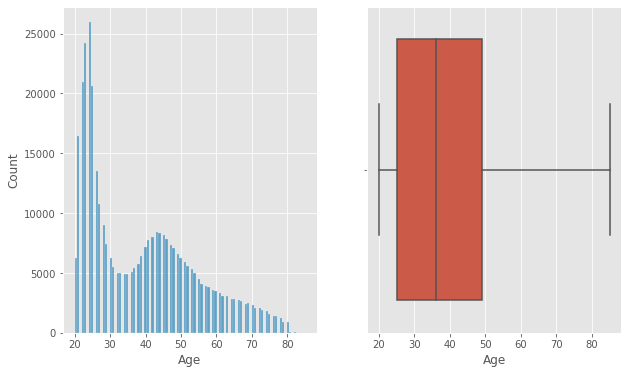

In [12]:
# histograma e boxplot
fig, axes = plt.subplots(1,2,figsize=(10,6))
sns.histplot(df['Age'], bins=calculate_bins(df,'Age'), ax=axes[0])
sns.boxplot(df['Age'], ax=axes[1]);

In [13]:
# assimetria
df['Age'].skew()

0.6725389977260843

- `Region_Code`

Grande maioria dos clientes na Region_Code = 28, sem presença de outliers e moderadamente assimétrica.

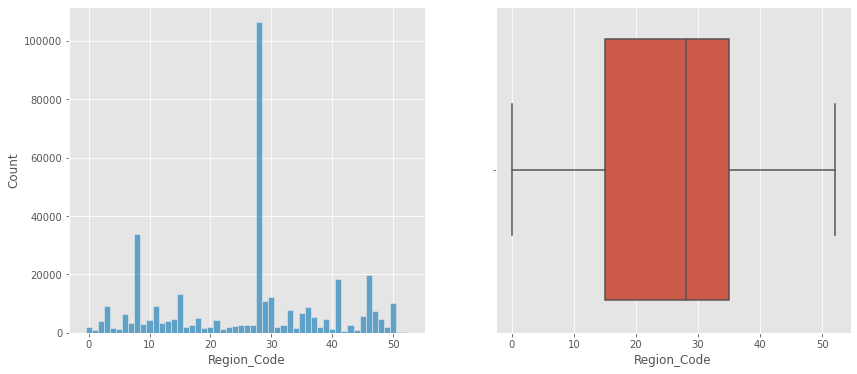

In [14]:
# histograma e boxplot
fig, axes = plt.subplots(1,2,figsize=(14,6))
sns.histplot(df['Region_Code'], discrete=True, element='bars', ax=axes[0])
sns.boxplot(df['Region_Code'], ax=axes[1]);

In [15]:
# moda
df['Region_Code'].mode()

0    28.0
dtype: float64

In [16]:
# assimetria
df['Region_Code'].skew()

-0.11526641488610123

- `Annual_Premium`

Grande presença de outliers e assimetria extrema à direita $\to$ transoformar variável ou remover outliers.

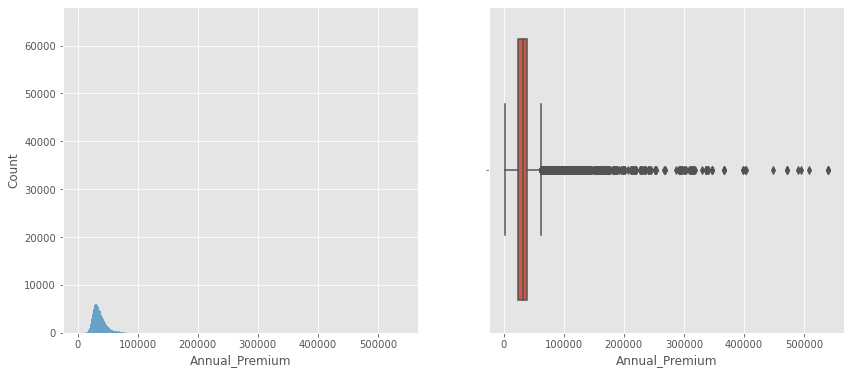

In [17]:
# histograma e boxplot a priori
fig, axes = plt.subplots(1,2,figsize=(14,6))
sns.histplot(df['Annual_Premium'], bins=calculate_bins(df,'Annual_Premium'), ax=axes[0])
sns.boxplot(df['Annual_Premium'], ax=axes[1]);

A transformação não foi capaz de remover completamente os outliers, porém foi capaz de reduzí-los, como é possível notar pelo valor da assimetria abaixo. Essa transformação é importante pois diversos algoritmos de aprendizado de máquina são sensíveis a outliers pois têm sua função objetivo assume que os atributos estão centrados em zero e possuem variância de mesma ordem e.g. SVM [[2]](https://scikit-learn.org/stable/modules/preprocessing.html).

In [18]:
# log transformation
Annual_Premium_log_ = np.log(np.array(df['Annual_Premium']))

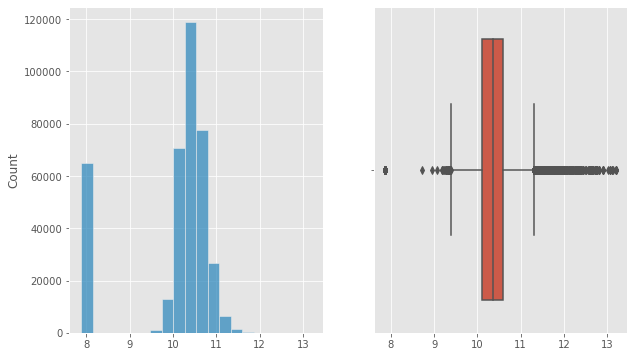

In [19]:
# histograma e boxplot a posteriori
fig, axes = plt.subplots(1,2,figsize=(10,6))
sns.histplot(Annual_Premium_log_, bins=20, ax=axes[0])
sns.boxplot(Annual_Premium_log_, ax=axes[1]);

In [20]:
# assimetria
from scipy.stats import skew as spskew

print('Assimetria a priori:',
    df['Annual_Premium'].skew(),
      '\nAssimetria a posteriori:',
      spskew(Annual_Premium_log_))

Assimetria a priori: 1.7660872148961309 
Assimetria a posteriori: -1.4706424135406546


Considerando que o dataset possui apenas 2.71% de outliers, sendo que os clientes com interesse no seguro presentes nos outliers (Response=1) representam apenas 15.07%, pode-se remover os outliers.

In [21]:
# método interquartil de remoção de outlers 
Q1 = np.percentile(np.array(df['Annual_Premium']),25)
Q3 = np.percentile(np.array(df['Annual_Premium']),75)
IQR = Q3 - Q1
minimum = Q1 - 1.5*IQR # whisker min
maximum = Q3 + 1.5*IQR # whisker max
minimum, maximum

(1912.5, 61892.5)

In [22]:
print('Dataset possui {}% de outliers, sendo que Reponse=1 corresponde a {}%.'.format(
    round(df.query('Annual_Premium<%s or Annual_Premium>%s'%(minimum,maximum)).shape[0]/df.shape[0]*100,2),
    round(df.query('Annual_Premium<%s or Annual_Premium>%s and Response==1'%(minimum,maximum)).shape[0]/\
          df.query('Annual_Premium<%s or Annual_Premium>%s'%(minimum,maximum)).shape[0]*100,2)
        )
)

Dataset possui 2.71% de outliers, sendo que Reponse=1 corresponde a 15.07%.


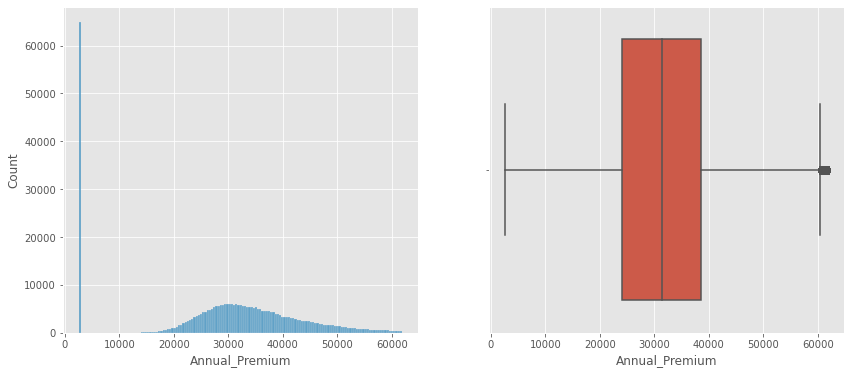

In [23]:
# histograma e boxplot com IQR outlier removal
fig, axes = plt.subplots(1,2,figsize=(14,6))
sns.histplot(df.query('%s<=Annual_Premium<=%s'%(minimum,maximum))['Annual_Premium'], 
             bins=calculate_bins(df.query('%s<=Annual_Premium<=%s'%(minimum,maximum)),
                                          'Annual_Premium'), ax=axes[0])
sns.boxplot(df.query('%s<=Annual_Premium<=%s'%(minimum,maximum))['Annual_Premium'], ax=axes[1]);

In [24]:
# remove outliers
df_ = df.query('%s<=Annual_Premium<=%s'%(minimum,maximum))

In [25]:
df_.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,0,44,1,28.0,0,2,1,40454.0,26.0,217,1
2,0,76,1,3.0,0,1,0,33536.0,26.0,183,0
3,0,47,1,28.0,0,2,1,38294.0,26.0,27,1
4,0,21,1,11.0,1,0,0,28619.0,152.0,203,0
5,1,29,1,41.0,1,0,0,27496.0,152.0,39,0


In [26]:
df.shape, df_.shape

((381109, 11), (370789, 11))

## Análise multivariada

Calculando o coeficiente de correlação $\tau$ de Kendall entre as variáveis, vemos que:
- Variáveis independentes:
    - Correlação positiva moderada entre `Age` e `Vehicle_Age`
    - Correlação negativa moderada entre `Age` e `Policy_Sales_Channel`
    - Correlação negativa forte entre `Previously_Insured` e `Vehicle_Damage`
    - Correlação negativa moderada entre `Previously_Insured` e `Vehicle_Age`
    - Correlação positiva moderada entre `Vehicle_Age` e `Vehicle_Damage`
    - Correlação negativa moderada entre `Vehicle_Age` e `Policy_Sales_Channel`

- Variável dependente:
    - Correlação negativa moderada entre `Response` e `Previously_Insured`
    - Correlação positiva moderada entre `Response` e `Vehicle_Damage`
    
PS: importante denotar que o coeficiente de correlação de Kendall é apropriado apra alguns casos, como correlação entre variáveis contínuas e ordinais com poucos níveis. Portanto uma análise primária foi feita acima, e abaixo serão realizados novos testes de associação/correlação entre as variáveis de acordo com cada tipo de variável, principalmente buscando associação entre as variáveis independentes e a variável dependente.

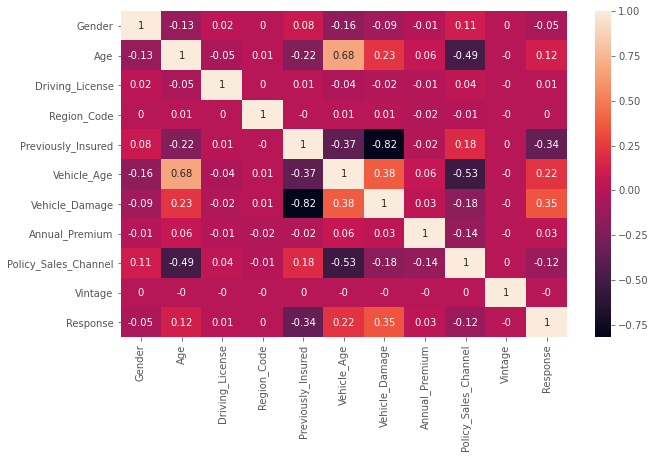

In [26]:
fig, ax=plt.subplots(figsize=(10,6))
sns.heatmap(df_.corr(method='kendall').round(2), annot=True, ax=ax);

In [27]:
df_.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [28]:
# cria dfs para Response==0 e Response==1
response0 = df_.query('Response==0') 
response1 = df_.query('Response==1')

Considerando apenas clientes interessados no seguro auto, temos que:

- Correlação positiva moderada entre `Age` e `Vehicle_Age`
- Correlação negativa moderada entre `Age` e `Policy_Sales_Channel`
- Correlação negativa moderada entre `Vehicle_Age` e `Policy_Sales_Channel`

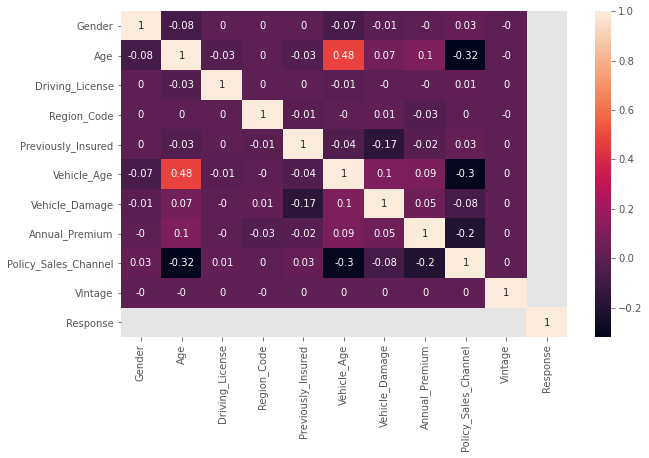

In [29]:
fig, ax=plt.subplots(figsize=(10,6))
sns.heatmap(response1.corr(method='kendall').round(2), annot=True, ax=ax);

### 1) Qual a taxa de interesse de seguros e taxa de desinteresse?


Taxa de interesse no seguro é muito baixa, de apenas 12%, enquanto a taxa de desinteresse, complementar, é de 88%. Nesse caso, a taxa de desinteresse possui o mesmo valor da taxa média de retenção de clientes por seguradoras de automóveis, como apresentado no início. A seguradora, portanto, está com um grande problema de retenção de clientes.

Isso demonstra como é importante criar uma solução para o time de vendas da empresa para priorizar os clientes que possuem interesse no seguro, como também elaborar um plano de marketing para talvez atrair mais clientes através de um rankeamento.

In [30]:
print('Taxa de interesse no seguro: {}%'.format(
    round(
    response1.shape[0]/df_.shape[0],2)
   )
)

Taxa de interesse no seguro: 0.12%


In [111]:
print('Taxa de desinteresse: {}%'.format(
    round(
    response0.shape[0]/df_.shape[0],2)
   )
)

Taxa de desinteresse: 0.88%


### 2) Existe uma grande diferença entre gêneros no interesse pelo seguro?

Tratando da proporção geral entre homens e mulheres, temos que:
- Response=0 $\to$ homens representam 56.6%, enquanto mulheres representam 41.2% do total
- Response=1 $\to$ homens representam 7.4%, enquanto mulheres representam 4.7% do total ($\Delta$ de 2.7%)

In [32]:
# porcentagem total
df_.groupby(['Response'])['Gender'].value_counts()/df_.shape[0]

Response  Gender
0         0         0.465933
          1         0.412286
1         0         0.074317
          1         0.047464
Name: Gender, dtype: float64

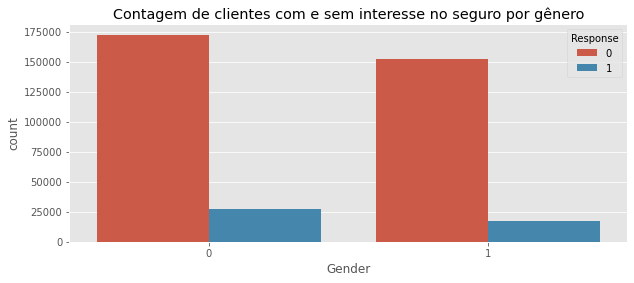

In [33]:
# plot de contagem
fig, ax = plt.subplots(figsize=(10,4))
sns.countplot('Gender',hue='Response',data=df_, ax=ax)
plt.title('Contagem de clientes com e sem interesse no seguro por gênero');

Aplicando o teste estatístico $\chi²$ para testar a hipótese de independência entre as variáveis `Gender` e `Response`, temos um p-value próximo a zero. Portanto, considerando as hipóteses nula $H_0$ de que as amostras são independentes, e alternativa $H_1$ de que as amostras são dependentes, a um nível de significância de 5%, o resultado de p-value nos leva a rejeitar $H_0$ pois não há evidência suficiente para aceitá-la, e aceitar $H_1$, ou seja, existe associação entre as variáveis.

In [34]:
# tabela de frequências
gender_ = pd.crosstab(df_['Response'], df_['Gender'])
gender_

Gender,0,1
Response,,
0,172763,152871
1,27556,17599


In [35]:
# estatística
from scipy.stats import chi2_contingency

chi2,p_value,_,_ = chi2_contingency(gender_)
chi2,p_value

(1014.1014095171608, 1.5457848327351606e-222)

Visando calcular quão forte é a associação, a estatística V de Cramérs corrigida [[3]](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V), [[4]](http://www.mat.ufrgs.br/~viali/estatistica/mat2282/material/laminaspi/Mat2282_CC), [[5]](https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix) foi determinada, resultando em uma associação fraca de 0.052.

Portanto, sumarizando, temos que as variáveis são dependentes, porém a associação entre elas é fraca. Entretanto, é importante recordar que a associação não necessariamente significa uma relação de causa e efeito, como também que a "Ausência de evidência não é evidência da ausência" [[6]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5042133/pdf/nihms-816857.pdf).

In [36]:
def cramers_V(table, chi2):
    """Calcula a estatística V de Cramérs para quantificar associação entre variáveis
        com correção de Bergsma e Wicher"""
    n = table.sum().sum()
    phi2 = chi2/n
    r,c = table.shape
    phi2corr = max(0, (phi2 - ((c-1)*(r-1))/(n-1)))
    rcorr = r - ((r-1)**2)/(n-1)
    ccorr = c - ((c-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((rcorr-1),(ccorr-1)))

In [37]:
# associação
round(cramers_V(gender_, chi2),3)

0.052

Analisando especificamente os clientes que apresentaram interesse no seguro auto, temos que ainda que a proporção de homens seja maior (54%), a proporção de homens (61%) com interesse no seguro é também superior que a de mulheres (38.9%).

In [38]:
# porcentagem
response1.groupby(['Response'])['Gender'].value_counts()/response1.shape[0]

Response  Gender
1         0         0.610254
          1         0.389746
Name: Gender, dtype: float64

Considerando clientes sem habilitação, a maioria é composta também por homens, com valor (67.5%) ainda superior a somente a consideração somente do gênero, ou seja, a variável de habilitação aumenta a probabilidade de interesse.

In [39]:
# taxa de resposta=1 por gênero sem habilitação
response1.query('Driving_License==0')['Gender'].value_counts()/\
    response1.query('Driving_License==0').shape[0]

0    0.675
1    0.325
Name: Gender, dtype: float64

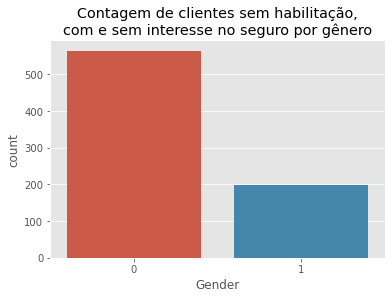

In [40]:
# contagem
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot('Gender',data=df_.query('Driving_License==0'), ax=ax)
plt.title('Contagem de clientes sem habilitação,\ncom e sem interesse no seguro por gênero');

In [41]:
# contagem
response1.groupby(['Gender'])['Previously_Insured'].value_counts()

Gender  Previously_Insured
0       0                     27463
        1                        93
1       0                     17538
        1                        61
Name: Previously_Insured, dtype: int64

### 3) Qual é o range de idade com maior interesse no seguro auto?

Nota-se pelo histograma abaixo que entre 30 e 60 anos o interesse pelo seguro auto aparenta ser superior e, portanto, pessoas mais jovens estão mais interessados no seguro auto. 

Aplicando uma função de integração para a aproximação da f.d.p., temos que a probabilidade de interesse no seguro auto para pessoas entre 40 e 50 anos é de 0.347, mais que o dobro da probabilidade das pessoas que não tem interesse para o mesmo range de idade.

Nota-se pelo histograma e dist. de frequências abaixo que as dist. não aparentam vir de uma distribuição normal, e também que as distribuições são bastante diferentes, pois a concentração de clientes com Response=0 é maior entre os mais jovens, em contraste com Response=1, onde a frequência é superior para clientes mais velhos.

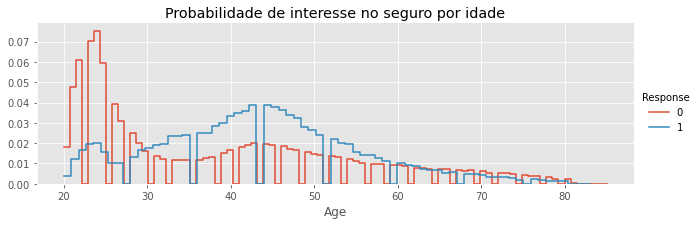

In [42]:
# hitograma
sns.FacetGrid(hue='Response', data=df_, height=3, aspect=3,
             ).map_dataframe(sns.histplot, 'Age',stat='probability', element='step', fill=False).add_legend()
plt.title('Probabilidade de interesse no seguro por idade');

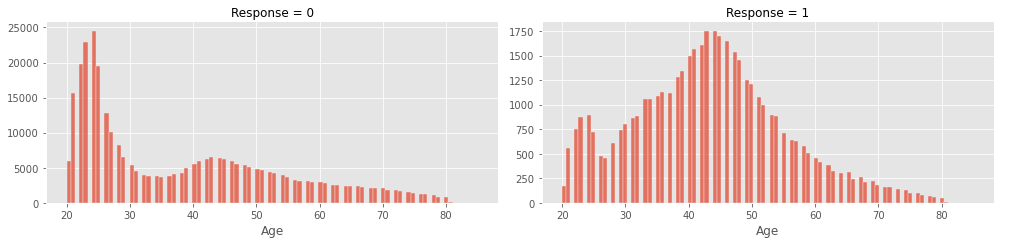

In [43]:
# frequências
sns.FacetGrid(col='Response', data=df_, height=3.5, aspect=2,
              sharey=False).map_dataframe(sns.histplot, 'Age', 
                                          bins=calculate_bins(df_,'Age')).add_legend();

Aplicando um teste estatístico não-paramétrico U de Mann-Whitney para testa a hipótese de amostras independentes para igualdade de medianas entre as variáveis `Age` e `Response`, ou seja, se uma população tende a ter valores mais que a outra [[7]](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html), [[8]](http://www.inf.ufsc.br/~vera.carmo/Testes_de_Hipoteses/Testes_nao_parametricos_Mann-Whitney.pdf), [[9]](http://www.portalaction.com.br/tecnicas-nao-parametricas/teste-de-wilcoxon-mann-whitney-amostras-independentes), considerando um nível de significância de 5%:

Hipóteses:
- $H_0: median_{Age,Response=0} = median_{Age,Response=1}$
- $H_1: median_{Age,Response=0} \ne median_{Age,Response=1}$ (two-tailed test)

O resultado aponta um p-value = 0. Podemos rejeitar a hipótese nula do teste de que as medianas são iguais pois não há evidência suficiente para aceitar tal hipótese pelos dados, aceitando, portanto, a hipótese alternativa de que as amostras possuem medianas diferentes, ou seja, são de populações diferentes.

PS: o teste não-paramétrico foi utilizado pois as distribuições não são normais, uma das premissas de um teste paramétrico como o teste-T, como pode ser visto pelas distribuições acima.

In [44]:
# teste
from scipy.stats import mannwhitneyu as utest

print('p-value:',
      utest(response0['Age'], response1['Age'])[1])

p-value: 0.0


Utilizando o teste de associação point biserial entre as variáveis, notamos pelo resultado uma associação positiva fraca de 0.111, ou seja, quando existe interesse no seguro auto, a tendência é que o cliente seja mais velho.

Nota-se, também, pelo resultado do p-value que a associação entre as variáveis, ainda que seja fraca, é estatisticamente significante, pois p-value < 5%.

In [45]:
# associação
from scipy.stats import pointbiserialr as pb

corr,p_value = pb(df_['Response'], df_['Age'])
corr,p_value

(0.11093768629523015, 0.0)

Visando calcular a probabilidade em determinadas regiões, como por exemplo entre 20 e 30 anos, onde a probabilidade de clientes com interesse no seguro aparenta ser superior à de clientes sem interesse, a função abaixo foi criada [[10]](https://github.com/admond1994/calculate-probability-from-probability-density-plots/blob/master/cal_probability.ipynb).

In [46]:
from sklearn.neighbors import KernelDensity

def calculate_probability(df, col, eval_points, start_value, end_value):
    """Calcula a probabilidade do campo através a integral aproximada da 
    função de densidade de probabilidade"""
    
    # reshape df
    df = np.array(df['%s'%col]).reshape(-1,1)
    
    # do kde
    kde_df = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(df)

    # number of eval points
    N = eval_points
    step = (end_value - start_value)/(N-1)
    
    x = np.linspace(start_value, end_value, N)[:, np.newaxis]
    
    # get samples
    kde_vals = np.exp(kde_df.score_samples(x))
    
    # integrate (app.) PDF
    probability = np.sum(kde_vals * step)
    
    return probability.round(4)

In [47]:
# range de idade
df_['Age'].min(), df_['Age'].max()

(20, 85)

Nota-se que para:
- 30-40 anos: probabilidade de resposta positiva é 0.24 contra 0.13 negativa
- 40-50 anos: probabilidade de resposta positiva é 0.347 contra 0.18 negativa
- 50-60 anos: probabilidade de resposta positiva é 0.174 contra 0.115 negativa

In [48]:
# probabilidades
print('[20-30]: Response=0:',
      calculate_probability(response0, 'Age', 300, 20, 30),
      'Response=1:',
      calculate_probability(response1, 'Age', 300, 20, 30)
)
print('[30-40]: Response=0:',
      calculate_probability(response0, 'Age', 300, 30, 40),
      'Response=1:',
      calculate_probability(response1, 'Age', 300, 30, 40)
)
print('[40-50]: Response=0:',
      calculate_probability(response0, 'Age', 300, 40, 50),
      'Response=1:',
      calculate_probability(response1, 'Age', 300, 40, 50)
)
print('[50-60]: Response=0:',
      calculate_probability(response0, 'Age', 300, 50, 60),
      'Response=1:',
      calculate_probability(response1, 'Age', 300, 50, 60)
)
print('[60-70]: Response=0:',
      calculate_probability(response0, 'Age', 300, 60, 70),
      'Response=1:',
      calculate_probability(response1, 'Age', 300, 60, 70)
)
print('[70-85]: Response=0:',
      calculate_probability(response0, 'Age', 300, 70, 85),
      'Response=1:',
      calculate_probability(response1, 'Age', 300, 70, 85)
)

[20-30]: Response=0: 0.4464 Response=1: 0.1455
[30-40]: Response=0: 0.1314 Response=1: 0.2443
[40-50]: Response=0: 0.1805 Response=1: 0.3467
[50-60]: Response=0: 0.1148 Response=1: 0.1724
[60-70]: Response=0: 0.0744 Response=1: 0.0665
[70-85]: Response=0: 0.0448 Response=1: 0.0256


Ademais, segmentando por gênero para os clientes com interesse no seguro auto, vemos que a média/mediana para os homens é maior que das mulheres.

In [49]:
# média e medianas
response1.groupby(['Gender'])['Age'].mean(), response1.groupby(['Gender'])['Age'].median()

(Gender
 0    44.045326
 1    42.056480
 Name: Age, dtype: float64,
 Gender
 0    44
 1    42
 Name: Age, dtype: int64)

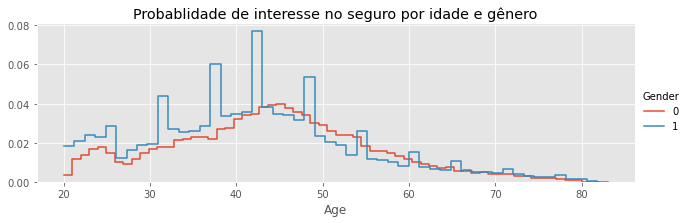

In [50]:
# histograma de idade por gênero para resposta=1
sns.FacetGrid(hue='Gender', data=response1, height=3, aspect=3,
             ).map_dataframe(sns.histplot, 'Age',stat='probability', element='step', fill=False).add_legend()
plt.title('Probablidade de interesse no seguro por idade e gênero');

Segmentando o interesse no seguro por idade do veículo, vemos que:
- Vehicle_Age=0 $\to$ clientes mais jovens (até 35 anos) com probabilidade de 0.97
- Vehicle_Age=1 $\to$ clientes em meia idade (35 - 45 anos) com probabilidade de 0.40
- Vehicle_Age=2 $\to$ clientes mais velhos (45 - 83 anos) com probabilidade de 0.77

Como apresentado no início, existe uma correlação positiva moderada entre idade do cliente e do veículo, como pode ser visto pela integral da f.d.p. da idade dos clientes segmentada por idade do veículo.

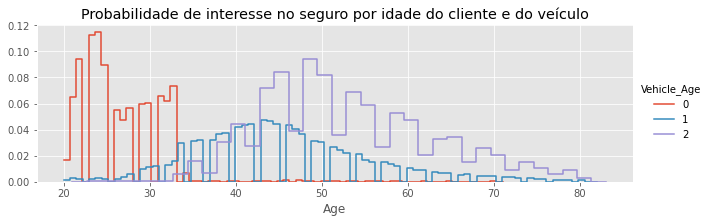

In [51]:
# hitograma
sns.FacetGrid(hue='Vehicle_Age', data=response1, height=3, aspect=3,
             ).map_dataframe(sns.histplot, 'Age',stat='probability', element='step', fill=False).add_legend()
plt.title('Probabilidade de interesse no seguro por idade do cliente e do veículo');

In [52]:
# probabilidades
print('[20-35]: Vehicle_Age=0:',
      calculate_probability(response1.query('Vehicle_Age==0'), 'Age', 300, 20, 35),
      'Vehicle_Age=1:',
      calculate_probability(response1.query('Vehicle_Age==1'), 'Age', 300, 20, 35),
      'Vehicle_Age=2:',
      calculate_probability(response1.query('Vehicle_Age==2'), 'Age', 300, 20, 35)
)
print('[35-45]: Vehicle_Age=0:',
      calculate_probability(response1.query('Vehicle_Age==0'), 'Age', 300, 35, 45),
      'Vehicle_Age=1:',
      calculate_probability(response1.query('Vehicle_Age==1'), 'Age', 300, 35, 45),
      'Vehicle_Age=2:',
      calculate_probability(response1.query('Vehicle_Age==2'), 'Age', 300, 35, 45)
)
print('[45-85]: Vehicle_Age=0:',
      calculate_probability(response1.query('Vehicle_Age==0'), 'Age', 300, 45, 85),
      'Vehicle_Age=1:',
      calculate_probability(response1.query('Vehicle_Age==1'), 'Age', 300, 45, 85),
      'Vehicle_Age=2:',
      calculate_probability(response1.query('Vehicle_Age==2'), 'Age', 300, 45, 85)
)

[20-35]: Vehicle_Age=0: 0.9717 Vehicle_Age=1: 0.1328 Vehicle_Age=2: 0.0135
[35-45]: Vehicle_Age=0: 0.0066 Vehicle_Age=1: 0.4002 Vehicle_Age=2: 0.2171
[45-85]: Vehicle_Age=0: 0.0124 Vehicle_Age=1: 0.4713 Vehicle_Age=2: 0.7733


Como apresentado no início da análise multivariada, existe uma correlação negativa entre `Age` e `Policy_Sales_Channel`. Abaixo vemos o gráfico de dispersão para clientes com interesse no seguro, onde clientes mais jovens tendem a utilizar os canais de número mais alto (>120), enquanto clientes mais velhos tendem a utilizar os canais de número mais baixo (<40).

Esta segmentação é importante, pois estabelece uma relação entre a idade dos clientes e seus canais de atendimentos preferidos.

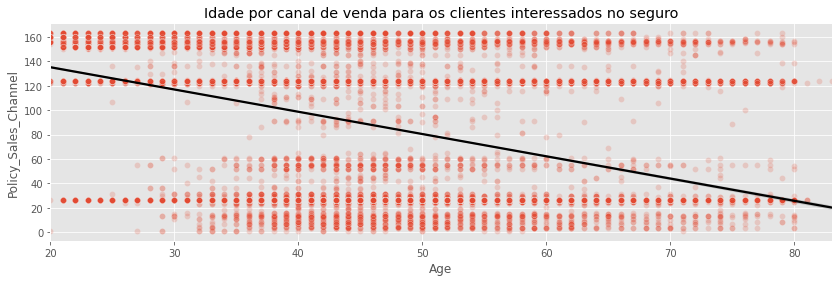

In [53]:
# dispersão
fig, ax=plt.subplots(figsize=(14,4))
sns.scatterplot(x='Age', y='Policy_Sales_Channel', data=response1, alpha=0.2, ax=ax)
sns.regplot(x='Age', y='Policy_Sales_Channel', data=response1, scatter=False, color='k', ax=ax)
ax.set_title('Idade por canal de venda para os clientes interessados no seguro');

### 4) Clientes com habilitação são propensos a possuir interesse no seguro auto?


Analisando em um contexto geral, observa-se que clientes com habilitação representam a maioria (99.79%):

- Response=0 $\to$ clientes com habilitação representam 87.6%, enquanto sem habilitação são 0.19%
- Response=1 $\to$ clientes com habilitação representam 12.1%, enquanto sem habilitação são 0.01%

In [54]:
# porcentagem total
df_['Driving_License'].value_counts()/df_.shape[0]

1    0.997942
0    0.002058
Name: Driving_License, dtype: float64

In [55]:
# porcentagem total
df_.groupby(['Response'])['Driving_License'].value_counts()/df_.shape[0]

Response  Driving_License
0         1                  0.876269
          0                  0.001950
1         1                  0.121673
          0                  0.000108
Name: Driving_License, dtype: float64

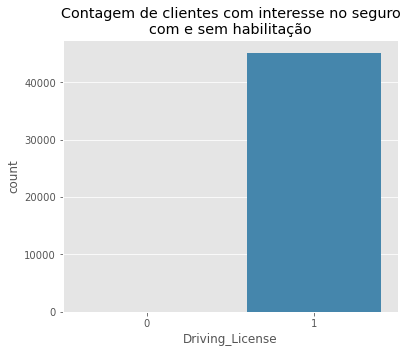

In [56]:
# contagem
fig, ax = plt.subplots(figsize=(6,5))
sns.countplot('Driving_License',data=response1, ax=ax)
plt.title('Contagem de clientes com interesse no seguro\ncom e sem habilitação');

Aplicando o teste estatístico $\chi²$ para testar a hipótese de independência entre as variáveis `Driving_License` e `Response`, considerando um nível de significância de 5%, temos como resultado um p-value próximo a zero. Portanto, rejeitamos $H_0$ pois não há evidência suficiente para aceitá-la, e aceitamos $H_1$ que nos diz que as variáveis estão associadas. 


In [57]:
# tabela de frequências
license_ = pd.crosstab(df_['Response'], df_['Driving_License'])
license_

Driving_License,0,1
Response,,
0,723,324911
1,40,45115


In [58]:
# estatística
chi2,p_value,_,_ = chi2_contingency(license_)
chi2,p_value

(33.74132468043467, 6.294914142770632e-09)


Calculando a estatística V de Cramérs, temos como resultado uma associação baixa de 0.009. Portanto, em suma, existe associação entre as variáveis, porém a mesma é fraca.

In [59]:
# associação
round(cramers_V(license_,chi2),3)

0.009

Tratando especificamente dos clientes que possuem interesse no seguro, vemos que majoritariamente os clientes possuem habilitação $\to$ 99.9%:

In [60]:
# porcentagem
response1.groupby(['Response'])['Driving_License'].value_counts()/response1.shape[0]

Response  Driving_License
1         1                  0.999114
          0                  0.000886
Name: Driving_License, dtype: float64

Analisando o segmento de clientes que não possuem habilitação mas possuem interesse no seguro auto, como apresentado no histograma abaixo, vemos que são clientes mais velhos (idade mínima de 44 anos), sendo que a probabilidade de interesse é superior para clientes sem habilitação e mais velhos do que para clientes com habilitação e mais velhos.

In [61]:
# idade mínima e máxima de clientes sem habilitação
response1.query('Driving_License==0')['Age'].min(), response1.query('Driving_License==0')['Age'].max()

(44, 75)

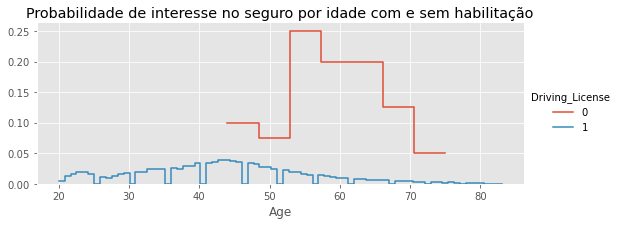

In [62]:
# histograma
sns.FacetGrid(hue='Driving_License', data=response1, height=3, aspect=2.5,
             ).map_dataframe(sns.histplot, 'Age',stat='probability', element='step', fill=False).add_legend()
plt.title('Probabilidade de interesse no seguro por idade com e sem habilitação');

Segmentação por idade e gênero para clientes sem habilitação mostra que existem mais homens (27) do que mulheres (14), porém com probabilidade de interesse equivalente, como visto no histograma abaixo, exceto entre 
60-65 anos, onde a probabilidade de ser homem é superior (0.26) à mulher (0.04), e  entre 65-70 anos, onde a probabilidade de ser mulher é superior (0.39) ao homem (0.05).

In [63]:
# contagem de clientes sem habilitação por gênero
response1.query('Driving_License==0').groupby(['Gender'])['Age'].count()

Gender
0    27
1    13
Name: Age, dtype: int64

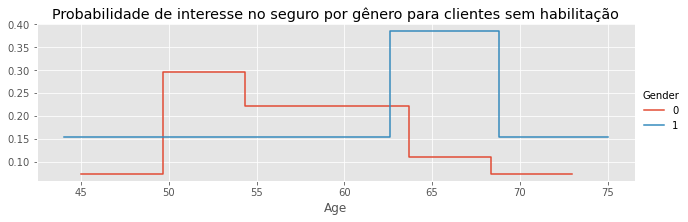

In [64]:
# histograma
sns.FacetGrid(hue='Gender', data=response1.query('Driving_License==0'), height=3, aspect=3,
             ).map_dataframe(sns.histplot, 'Age',stat='probability', element='step', fill=False).add_legend()
plt.title('Probabilidade de interesse no seguro por gênero para clientes sem habilitação');

In [65]:
# probabilidades
print('[60-65]: Gênero=Homen:',
      calculate_probability(response1.query('Driving_License==0 and Gender==0'), 
                            'Age', 100, 60, 65),
      'Gênero=Mulher:',
      calculate_probability(response1.query('Driving_License==0 and Gender==1'),
                            'Age', 100, 60, 65)
)
print('[65-70]: Gênero=Homen:',
      calculate_probability(response1.query('Driving_License==0 and Gender==0'), 
                            'Age', 300, 65, 70),
      'Gênero=Mulher:',
      calculate_probability(response1.query('Driving_License==0 and Gender==1'),
                            'Age', 300, 65, 70)
)

[60-65]: Gênero=Homen: 0.2582 Gênero=Mulher: 0.042
[65-70]: Gênero=Homen: 0.0567 Gênero=Mulher: 0.4202


### 5) Alguma região apresenta mais clientes com interesse no seguro?


Nota-se, dentre 53 regiões diferentes, a região 28 possui aproximadamente 27% dos clientes da seguradora, e que as 5 primeiras regiões correspondema a aproximadamente 50% dos clientes, como visto abaixo.

O histograma abaixo demonstra visualmente a região 28, onde a presença de clientes é muito superior às demais, e a probabilidade de interesse para tal região é superior à de não interesse.

In [53]:
# número de regiões
df_['Region_Code'].nunique()

53

In [54]:
# head
print((df_['Region_Code'].value_counts()/df_.shape[0]).to_frame().head(5).sum())
(df_['Region_Code'].value_counts()/df_.shape[0]).to_frame().head(5)

Region_Code    0.492347
dtype: float64


,Region_Code
28.0,0.268997
8.0,0.086489
46.0,0.052936
41.0,0.048386
15.0,0.035540


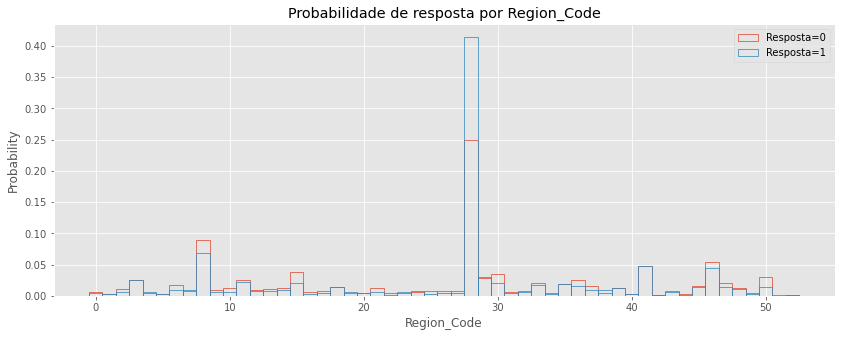

In [66]:
# probabilidade de resposta por região
fig, ax = plt.subplots(figsize=(14,5))
sns.histplot(x='Region_Code', data=response0, stat='probability', 
             fill=False, element='bars', discrete=True, label='Resposta=0', ax=ax)
sns.histplot(x='Region_Code', data=response1, stat='probability', 
             fill=False, element='bars', discrete=True, label='Resposta=1', ax=ax)
plt.legend()
plt.title('Probabilidade de resposta por Region_Code');

Utilizando o teste de associação point biserial entre as variáveis, notamos pelo resultado uma associação positiva fraca de 0.01, ou seja, quando existe interesse no seguro auto, a tendência é que o cliente seja de uma região de número mais elevado.

Nota-se, também, pelo resultado do p-value que a associação entre as variáveis, ainda que seja fraca, é estatisticamente significante, pois p-value < 5%.

In [67]:
# associação
corr,p_value = pb(df_['Response'], df_['Region_Code'])
corr,p_value

(0.009473616453076993, 7.982529625105162e-09)

Como comentado, Region_Code = 28 possui 26.9% do total de clientes da seguradora, e apresenta também a maior taxa de interesse no seguro auto, de 41.42%, apresentando, portanto, maior probabilidade de resposta que as demais regiões, como pôde-se observar no histograma acima.

In [68]:
print(
    'Region_Code=28 representa {}%'.format(
        round((df_.query('Region_Code==28')['Region_Code'].value_counts()/\
               df_.shape[0]).values[0]*100,2)),
    'do dataset, mas possui uma taxa de Response=1 de {}%'.format(
        round((response1.query('Region_Code==28')['Region_Code'].value_counts()/\
            response1.shape[0]).values[0]*100,2))
)

Region_Code=28 representa 26.9% do dataset, mas possui uma taxa de Response=1 de 41.42%


Nota-se abaixo que o histograma da idade dos clientes clientes da Region_Code=28 é muito similar à dos clientes com interesse no seguro i.e. Response=1, com maior probabilidade de pessoas mais velhas (> 40 anos), como apresentado acima na análise da idade dos clientes, enquanto o histograma dos clientes de outras regiões é similar ao dos clientes que não apresentaram interesse no seguro.

In [69]:
region_28 = df_.query('Region_Code==28')
regions_other = df_.query('Region_Code!=28')

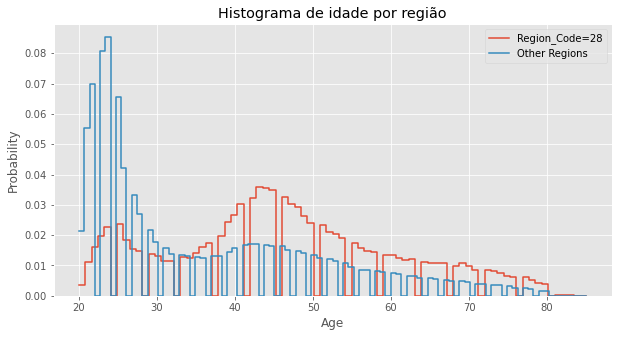

In [118]:
fig, ax=plt.subplots(figsize=(10,5))
sns.histplot(x='Age', data=region_28, stat='probability', 
             fill=False, element='step', label='Region_Code=28', ax=ax)
sns.histplot(x='Age',data=regions_other, stat='probability',
            fill=False, element='step', label='Other Regions', ax=ax)
plt.legend()
ax.set(title='Histograma de idade por região');

### 6) Os clientes já assegurados têm tendência de permanecer ou cancelam o seguro (churn)?


Analisando em um contexto geral, observa-se que clientes com habilitação representam a maioria (99.79%):

- Response=0 $\to$ clientes anteriormente assegurados representam 45.9%, enquanto sem seguro são 41.9%
- Response=1 $\to$ clientes anteriormente assegurados representam 0.04%, enquanto sem seguro são 12.1%, ou seja, clientes anteriormente assegurados são minoria

Entretanto, nota-se abaixo que a taxa de cancelamento para clientes que possuíam o seguro é extremamente alta (a porcentagem mais alta entre as respostas segmentando por seguro), de 45.9%. Ou seja, praticamente todos os clientes que possuíam seguro o estão cancelando.

In [71]:
# porcentagem total
df_.groupby(['Response'])['Previously_Insured'].value_counts()/df_.shape[0]

Response  Previously_Insured
0         1                     0.459250
          0                     0.418969
1         0                     0.121366
          1                     0.000415
Name: Previously_Insured, dtype: float64

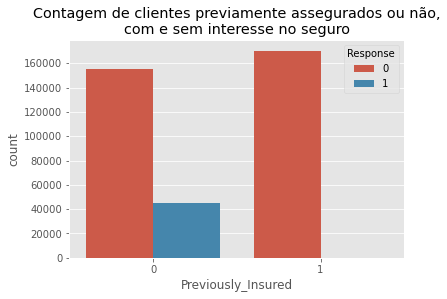

In [72]:
# contagem
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot('Previously_Insured', hue='Response', data=df_, ax=ax)
plt.title('Contagem de clientes previamente assegurados ou não,\ncom e sem interesse no seguro');

Aplicando o teste estatístico $\chi²$ para testar a hipótese de independência entre as variáveis `Previously_Insured` e `Response`, considerando um nível de significância de 5%, temos como resultado um p-value de zero. Portanto, rejeitamos $H_0$ pois não há evidência suficiente para aceitá-la, e aceitamos $H_1$ que nos diz que as variáveis estão associadas. 

In [73]:
# tabela de frequências
prev_insurance_ = pd.crosstab(df_['Previously_Insured'], df_['Response'])
prev_insurance_

Response,0,1
Previously_Insured,,
0,155349,45001
1,170285,154


In [74]:
# estatísticas
chi2,p_value,_,_ = chi2_contingency(prev_insurance_)
chi2,p_value

(43091.63781208705, 0.0)

Calculando a estatística V de Cramérs, temos como resultado uma associação moderada de 0.341.

In [75]:
# associação
cramers_V(prev_insurance_, chi2)

0.34090127535864234

Analisando especificamente clientes com Response=1, temos que a porcentagem de clientes que apresentaram interesse mas que não eram anteriormente clientes da seguradora é de 99.6%.

In [76]:
# porcentagem
response1.groupby(['Response'])['Previously_Insured'].value_counts()/response1.shape[0]

Response  Previously_Insured
1         0                     0.99659
          1                     0.00341
Name: Previously_Insured, dtype: float64

Observa-se também que dentre os clientes que possíam seguro anteriormente, 99.9% não apresentaram interesse em continuar com o seguro auto i.e. cancelamento. Portanto, a taxa de assegurados que cancelam o seguro é extremamente alta.

In [77]:
# porcentagem
df_.query('Previously_Insured==1')['Response'].value_counts()/\
    df_.query('Previously_Insured==1').shape[0]

0    0.999096
1    0.000904
Name: Response, dtype: float64

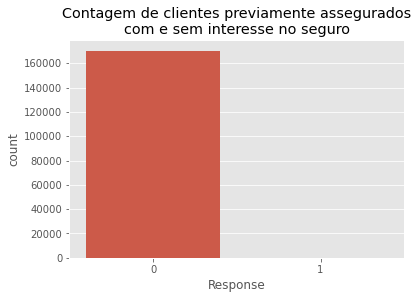

In [78]:
# contagem
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(df_.query('Previously_Insured==1')['Response'], ax=ax)
plt.title('Contagem de clientes previamente assegurados\ncom e sem interesse no seguro');

Vemos abaixo que os clientes com churn representam aproximadamente metade dos clientes com Response=0, os quais possuem o mesmo perfil de idade dos clientes de regiões diferentes da 28.

Através do gráfico de contagens abaixo, observa-se que a grande maioria (94.4%) dos clientes que apresentaram churn não tiveram seu carro danificado. 

In [49]:
# cria df para churn
churn_ = df_.query('Previously_Insured==1 and Response==0') 

In [61]:
print('Clientes com churn representam {}% dos clientes com Response=0.'.format(
    round(churn_.shape[0]/response0.shape[0]*100,2))
)

Clientes com churn representam 52.29% dos clientes com Response=0.


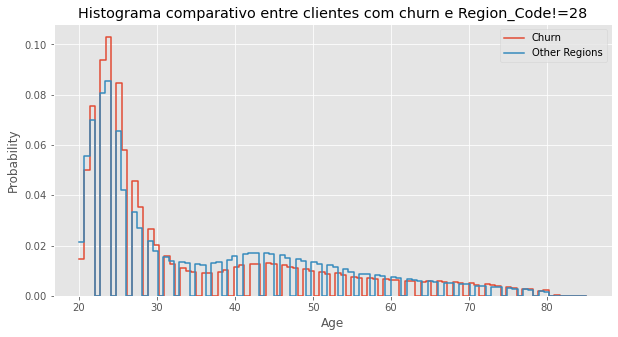

In [74]:
# histograma
fig, ax=plt.subplots(figsize=(10,5))
sns.histplot(x='Age', data=churn_, stat='probability', element='step', 
             fill=False, label='Churn', ax=ax)
sns.histplot(x='Age',data=regions_other, stat='probability',
            fill=False, element='step', label='Other Regions', ax=ax)
plt.legend()
plt.title('Histograma comparativo entre clientes com churn e Region_Code!=28');

In [75]:
# porcentagem
print('{}% dos clientes com churn não tiveram seu veículo danificado'.format(
    round(churn_.query('Vehicle_Damage==0').shape[0]/churn_.shape[0]*100,2))
)

94.37% dos clientes com churn não tiveram seu veículo danificado


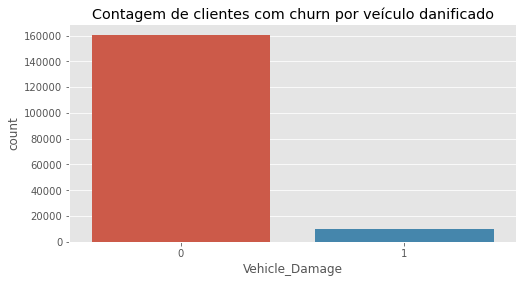

In [67]:
# contagem
plt.figure(figsize=(8,4))
sns.countplot(churn_['Vehicle_Damage'])
plt.title('Contagem de clientes com churn por veículo danificado');

### 7) Clientes com veículos mais velhos tendem a ter maior interesse no seguro auto?

Observa-se que entre os clientes sem interesse no seguro, 43% possuem veículos entre 1-2 anos, 41% veículos com menos de 1 ano, e apenas 2.9% apresentam carros com mais de 2 anos.

Para os clientes que apresentaram interesse no seguro a tendência é similar, onde 9.1% possuem veículos entre 1-2 anos, 1.9% veículos com menos de 1 ano, e 1.1% veículos com mais de dois anos. Nesse caso, a probabilidade para clientes que apresentaram interesse e possuem veículo com idade entre 1-2 anos é superior a 0.7, sendo, portanto, fortemente significativa.

In [79]:
# porcentagem total
df_.groupby(['Response'])['Vehicle_Age'].value_counts()/df_.shape[0]

Response  Vehicle_Age
0         1              0.432772
          0              0.416644
          2              0.028803
1         1              0.091009
          0              0.019040
          2              0.011732
Name: Vehicle_Age, dtype: float64

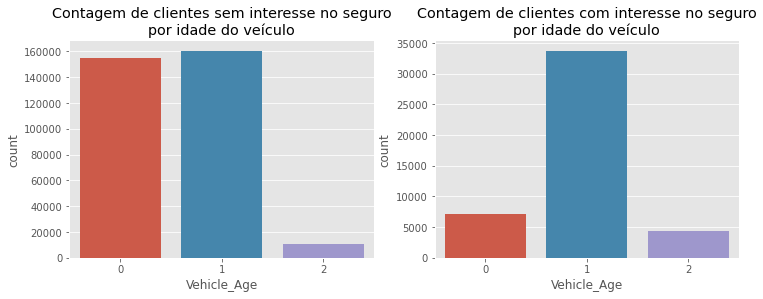

In [107]:
# contagem
# idade do veículo: 1 = [0,1]; 2 = [1,2]; 3 = >2
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
sns.countplot(response0['Vehicle_Age'], ax=ax1)
ax1.set_title('Contagem de clientes sem interesse no seguro\npor idade do veículo')
sns.countplot(response1['Vehicle_Age'], ax=ax2)
ax2.set_title('Contagem de clientes com interesse no seguro\npor idade do veículo');

Aplicando o teste estatístico $\chi²$ para testar a hipótese de independência entre as variáveis `Vehicle_Age` e `Response`, considerando um nível de significância de 5%, temos como resultado um p-value de zero. Portanto, rejeitamos $H_0$ pois não há evidência suficiente para aceitá-la, e aceitamos $H_1$ que nos diz que as variáveis estão associadas. 

In [81]:
# tabela de frequências
auto_age_ = pd.crosstab(df_['Vehicle_Age'], df_['Response'])
auto_age_

Response,0,1
Vehicle_Age,,
0,154487,7060
1,160467,33745
2,10680,4350


In [82]:
# estatísticas
chi2,p_value,_,_ = chi2_contingency(auto_age_)
chi2,p_value

(18062.75209221158, 0.0)

Calculando a estatística V de Cramérs, temos como resultado uma associação moderada de 0.221.

In [83]:
# associação
round(cramers_V(auto_age_, chi2),3)

0.221

Tratando especificamente de Response=1, temos que clientes com:

- Vehicle_Age=0 $\to$ 15.6%
- Vehicle_Age=1 $\to$ 74.7%
- Vehicle_Age=2 $\to$ 9.6%

In [84]:
# porcentagem
response1['Vehicle_Age'].value_counts()/response1.shape[0]

1    0.747315
0    0.156350
2    0.096335
Name: Vehicle_Age, dtype: float64

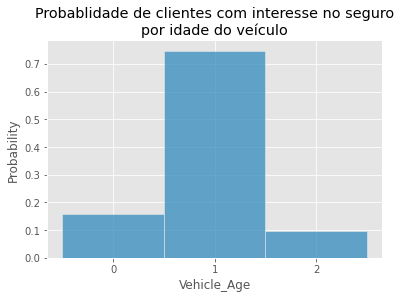

In [85]:
# histograma
# idade do veículo: 1 = [0,1]; 2 = [1,2]; 3 = >2
fig, ax=plt.subplots(figsize=(6,4))
sns.histplot(response1['Vehicle_Age'], stat='probability', element='bars', 
             discrete=True, ax=ax)
plt.xticks([0,1,2])
plt.title('Probablidade de clientes com interesse no seguro\npor idade do veículo');

### 8) Clientes que possuem carros já danificados têm maior interesse no seguro auto?

Dentre o total de clientes, 49% não tiveram o carro danificado e também não apresentaram interesse no seguro, enquanto 38.4% tiveram o carro danificado mas não apresentaram interesse no seguro. 

Já entre os clientes com interesse no seguro, 11.9% tiveram o carro danificado, o que representa 97.9% dos clientes que apresentaram interesse e já teve seu veículo danificado, enquanto clientes com interesse mas sem carro danificado representam a minoria, 0.2%.

In [86]:
# porcentagem total
df_.groupby(['Response'])['Vehicle_Damage'].value_counts()/df_.shape[0]

Response  Vehicle_Damage
0         0                 0.494246
          1                 0.383973
1         1                 0.119173
          0                 0.002608
Name: Vehicle_Damage, dtype: float64

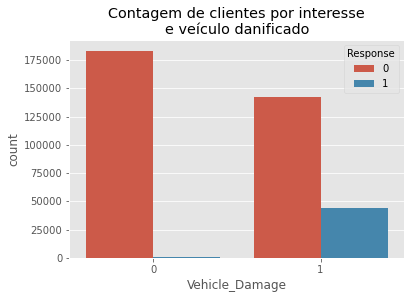

In [87]:
# contagem
sns.countplot(x='Vehicle_Damage', hue='Response', data=df_)
plt.title('Contagem de clientes por interesse\ne veículo danificado');

Aplicando o teste estatístico $\chi²$ para testar a hipótese de independência entre as variáveis `Vehicle_Damage` e `Response`, considerando um nível de significância de 5%, temos como resultado um p-value de zero. Portanto, rejeitamos $H_0$ pois não há evidência suficiente para aceitá-la, e aceitamos $H_1$ que nos diz que as variáveis estão associadas. 

In [88]:
# tabela de frequências
auto_damage_ = pd.crosstab(df_['Vehicle_Damage'], df_['Response'])
auto_damage_

Response,0,1
Vehicle_Damage,,
0,183261,967
1,142373,44188


In [89]:
# estatísticas
chi2,p_value,_,_ = chi2_contingency(auto_damage_)
chi2,p_value

(46488.90194652694, 0.0)

Calculando a estatística V de Cramérs, temos como resultado uma associação moderada de 0.354.

In [90]:
# associação
round(cramers_V(auto_damage_, chi2),3)

0.354

Tratando-se de clientes com interesse no seguro, temos que a grande maioria teve seu veículo danificado $\to$97.8%, o que é esperado, pois o comum é procurar uma seguradora para evitar problemas futuros quando seu veículo é foi danificado no passado.

In [91]:
# porcentagem
response1['Vehicle_Damage'].value_counts()/response1.shape[0]

1    0.978585
0    0.021415
Name: Vehicle_Damage, dtype: float64

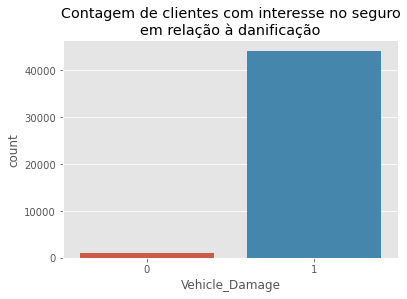

In [92]:
# contagem
fig, ax=plt.subplots(figsize=(6,4))
sns.countplot(response1['Vehicle_Damage'], ax=ax)
plt.title('Contagem de clientes com interesse no seguro\nem relação à danificação');

### 9) Valor do prêmio influencia no interesse do seguro?

Analisando os histogramas abaixo, nota-se que as distribuições aparentam ser semelhantes para clientes com Response=0 e Response=1, ou seja, não há grande diferência entre clientes em relação ao prêmio.

In [27]:
df_['Annual_Premium'].describe()

count    370789.000000
mean      29264.643973
std       14743.056656
min        2630.000000
25%       24102.000000
50%       31319.000000
75%       38596.000000
max       61892.000000
Name: Annual_Premium, dtype: float64

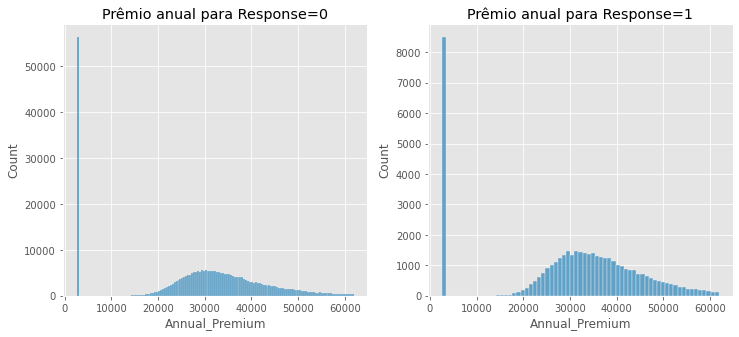

In [97]:
# histograma
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
sns.histplot(x='Annual_Premium', data=df_.query('Response==0'), ax=ax1)
ax1.set(title='Prêmio anual para Response=0')
sns.histplot(x='Annual_Premium', data=df_.query('Response==1'), ax=ax2)
ax2.set(title='Prêmio anual para Response=1');

Aplicando os testes para verificar se as distribuições diferem de uma dist. normal, temos um p-value resultante próximo a zero para ambos os casos, o que nos leva a rejeitar a hipótese nula pois não há evidência suficiente para aceitar tal hipótese, e aceitar a hipótese alternativa de que as distribuições vêm de uma dist. normal.

In [94]:
from scipy.stats import normaltest

print('Response=0: p_value={}'.format(
    normaltest(response0['Annual_Premium'])[1]))
print('Response=1: p_value={}'.format(
    normaltest(response1['Annual_Premium'])[1]))

Response=0: p_value=0.0
Response=1: p_value=0.0


In [95]:
from scipy.stats import shapiro

print('Response=0: p_value={}'.format(
    shapiro(response0['Annual_Premium'])[1]))
print('Response=1: p_value={}'.format(
    shapiro(response1['Annual_Premium'])[1]))

Response=0: p_value=0.0
Response=1: p_value=0.0


Aplicando um teste estatístico paramétrico teste-T para amostras independentes para testar a hipótese que as amostras possuem médias (valor esperado) idênticas entre as variáveis `Annual_Premium` e `Response`, considerando um nível de significância $\alpha$ = 5%, ou seja:

Hipóteses:
- $H_0: \mu_{AnnualPremium,Response=0} = \mu_{AnnualPremium,Response=1}$
- $H_1: \mu_{AnnualPremium,Response=0} \ne \mu_{AnnualPremium,Response=0}$ (two-tailed test)

O resultado aponta um p-value de $\approx$ 0 (two-sided test default), onde não há evidência suficiente para rejeitar a hipótese nula de que as amostras possuem médias idênticas, ou seja, o valor esperado da população de clientes com interesse no seguro é igual ao da população que não possui interesse no seguro quando comparados os valores de prêmio anual.

PS: importante denotar que como as amostras são suficiente grandes (>>30), o resultado de um teste-T é significativamente semelhante a um teste-z.

In [96]:
# variâncias 
response0['Annual_Premium'].var(), response1['Annual_Premium'].var()

(213844226.06887355, 242085258.53835455)

In [97]:
from scipy.stats import ttest_ind as ttest

print('p-value:',
      ttest(response0['Annual_Premium'], response1['Annual_Premium'])[1])

p-value: 1.2247023119891453e-29


Nota-se, abaixo, que as probabilidades calculadas por regiões são relativamente similares, ou seja, não há uma probabilidade muito superior em alguma região calculada para clientes com interesse no seguro.

In [98]:
# probabilidades
print('[0k-10k]: Response=0:',
      calculate_probability(response0, 'Annual_Premium', 10000, 0, 10000),
      'Response=1:',
      calculate_probability(response1, 'Annual_Premium', 10000, 0, 10000),
)
print('[10k-20k]: Response=0:',
      calculate_probability(response0, 'Annual_Premium', 10000, 10000, 20000),
      'Response=1:',
      calculate_probability(response1, 'Annual_Premium', 10000, 10000, 20000),
)
print('[20k-30k]: Response=0:',
      calculate_probability(response0, 'Annual_Premium', 10000, 20000, 30000),
      'Response=1:',
      calculate_probability(response1, 'Annual_Premium', 10000, 20000, 30000),
)
print('[30k-40k]: Response=0:',
      calculate_probability(response0, 'Annual_Premium', 10000, 30000, 40000),
      'Response=1:',
      calculate_probability(response1, 'Annual_Premium', 10000, 30000, 40000),
)
print('[40k-50k]: Response=0:',
      calculate_probability(response0, 'Annual_Premium', 10000, 40000, 50000),
      'Response=1:',
      calculate_probability(response1, 'Annual_Premium', 10000, 40000, 50000),
)
print('[50k-65k]: Response=0:',
      calculate_probability(response0, 'Annual_Premium', 15000, 50000, 65000),
      'Response=1:',
      calculate_probability(response1, 'Annual_Premium', 15000, 50000, 65000),
)

[0k-10k]: Response=0: 0.1729 Response=1: 0.1882
[10k-20k]: Response=0: 0.0165 Response=1: 0.0102
[20k-30k]: Response=0: 0.2634 Response=1: 0.212
[30k-40k]: Response=0: 0.3379 Response=1: 0.332
[40k-50k]: Response=0: 0.1521 Response=1: 0.1834
[50k-65k]: Response=0: 0.057 Response=1: 0.0741


Aproximadamente 17.5% dos clientes possuem o mesmo valor de prêmio anual de \\$2630. Destes, 86.9% não apresentaram interesse no seguro contra 13.1% que apresentaram interesse.

In [99]:
# porcentagem
df_[df_['Annual_Premium']<10000]['Annual_Premium'].value_counts()/df_.shape[0]

2630.0    0.174970
7670.0    0.000003
6098.0    0.000003
9816.0    0.000003
9792.0    0.000003
8739.0    0.000003
Name: Annual_Premium, dtype: float64

In [100]:
# porcentagem
df_[df_['Annual_Premium']<5000].groupby(['Response'])['Annual_Premium'].value_counts()/\
    df_[df_['Annual_Premium']<5000].shape[0]

Response  Annual_Premium
0         2630.0            0.868906
1         2630.0            0.131094
Name: Annual_Premium, dtype: float64

Como pode-se observar abaixo, dentre os clientes com prêmio igual a \\$2630, apenas 13% apresentaram interesse no seguro. Entretanto, de tais, 96.36% apresentaram veículo danificado, ou seja, majoritariamente, os clientes com menor prêmio e interesse no seguro possuem um veículo danificado.

In [80]:
print('Dentre {} clientes com prêmio = $2630:'.format(
    df_.query('Annual_Premium<5000').shape[0] # premio < 5000
    ), 
      '\n{} possuem interesse no seguro e {} deles apresentaram veículo danificado,'.format(
    response1.query('Annual_Premium<5000').shape[0], # premio < 5000 e response=1
    response1.query('Annual_Premium<5000 and Vehicle_Damage==1').shape[0] # premio < 5000, response=1, damage=1
    ),
      '\no que corresponse a {}% dos clientes com interesse no seguro no range de prêmio.'.format(
      round(response1.query('Annual_Premium<5000 and Vehicle_Damage==1').shape[0]/\
        response1.query('Annual_Premium<5000').shape[0]*100,2)
      )
)

Dentre 64877 clientes com prêmio = $2630: 
8505 possuem interesse no seguro e 8195 deles apresentaram veículo danificado, 
o que corresponse a 96.36% dos clientes com interesse no seguro no range de prêmio.


Abaixo, comparando os perfils de clientes com prêmio anual superior a \\$10k com clientes sem interesse no seguro, vemos que o perfil de idade é muito similar, principalmente para clientes mais jovens (< 30 anos) quando comparados com clientes que apresentaram interesse no seguro. Isso era esperado, pois os clientes com prêmio superior a 10k sem interesse no seguro correspondem a 88% do total de clientes em tal range de prêmio.

In [82]:
# cria df para prêmio superior a 10k
premium_ = df_[df_['Annual_Premium']>=10000]

In [100]:
print('{}% dos clientes com premium > $10k não possuem interesse no seguro.'.format(
round(premium_.query('Response==0').shape[0]/premium_.shape[0]*100,2))
     )

88.02% dos clientes com premium > $10k não possuem interesse no seguro.


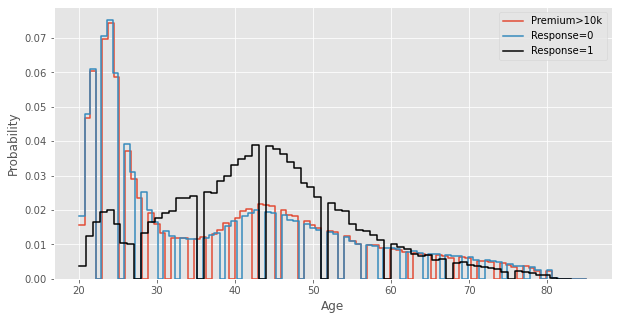

In [101]:
fig, ax=plt.subplots(figsize=(10,5))
sns.histplot(x='Age', data=premium_, stat='probability', element='step', 
             fill=False, label='Premium>10k', ax=ax)
sns.histplot(x='Age', data=response0, stat='probability', element='step', 
             fill=False, label='Response=0',ax=ax)
sns.histplot(x='Age', data=response1, stat='probability', element='step', 
             fill=False, label='Response=1', color='k', ax=ax)
plt.legend();

### 10) Algum canal de vendas para os clientes aumenta a propensão de interesse no seguro?

Como pode-se notar abaixo, o canal mais utilizado pelos clientes foi o canal 152, seguido pelo canal 26. Dentre 155 canais, abaixo são apresentados os 5 canais mais utilizados pelos clientes, que representam 84.3% dos canais escolhidos pelos clientes.

In [104]:
# número de canais
df_['Policy_Sales_Channel'].nunique()

155

In [105]:
# head
print((df_['Policy_Sales_Channel'].value_counts()/df_.shape[0]).to_frame().head(5).sum())
(df_['Policy_Sales_Channel'].value_counts()/df_.shape[0]).to_frame().head(5)

Policy_Sales_Channel    0.842865
dtype: float64


,Policy_Sales_Channel
152.0,0.356451
26.0,0.205980
124.0,0.193916
160.0,0.057955
156.0,0.028563


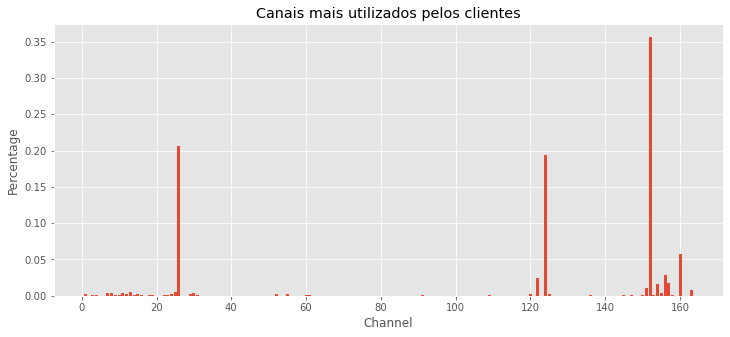

In [106]:
# bar
fig, ax=plt.subplots(figsize=(12,5))
ax.bar(np.array((df_['Policy_Sales_Channel'].value_counts()/df_.shape[0]).to_frame().index),
    (df_['Policy_Sales_Channel'].value_counts()/df_.shape[0]).values)
ax.set(xlabel='Channel', ylabel='Percentage', title='Canais mais utilizados pelos clientes');

Utilizando o teste de associação point biserial entre as variáveis, notamos pelo resultado uma correlação negativa fraca de 0.137, ou seja, quando existe interesse no seguro auto, a tendência é que o cliente utilize um canal de número menos elevado.

Nota-se, também, pelo resultado do p-value que a associação entre as variáveis, ainda que seja fraca, é estatisticamente significante, pois p-value < 5%.

In [107]:
# associação
corr,p_value = pb(df_['Response'], df_['Policy_Sales_Channel'])
corr,p_value

(-0.13680463988235436, 0.0)

Abaixo, nota-se que o canal mais utilizado por clientes com Response=1 foi o canal 26, seguido pelo 124, os quais somam 63.3% da clientela. Nota-se também que os 5 canais mais utilizados, como visto abaixo, somam 81%, ou seja, 81% dos clientes que apresentaram interesse no seguro utilizaram tais canais.

In [108]:
print((response1['Policy_Sales_Channel'].value_counts()/response1.shape[0]).to_frame().head(5).sum())
(response1['Policy_Sales_Channel'].value_counts()/response1.shape[0]).to_frame().head(5)

Policy_Sales_Channel    0.810099
dtype: float64


,Policy_Sales_Channel
26.0,0.334027
124.0,0.302026
152.0,0.084177
156.0,0.050448
157.0,0.039420


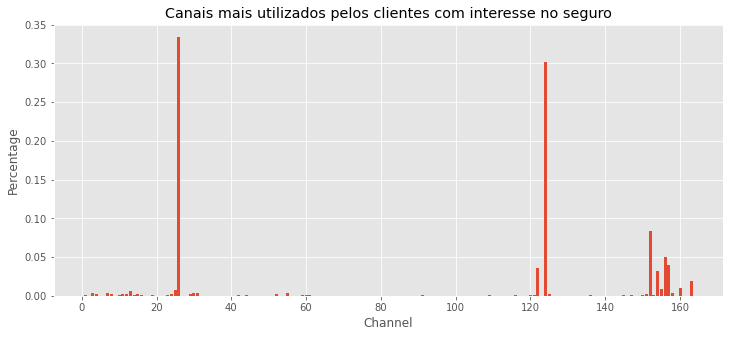

In [109]:
# bar
fig, ax=plt.subplots(figsize=(12,5))
ax.bar(np.array((response1['Policy_Sales_Channel'].value_counts()/response1.shape[0]).to_frame().index),
    (response1['Policy_Sales_Channel'].value_counts()/response1.shape[0]).values)
ax.set(xlabel='Channel', ylabel='Percentage', 
       title='Canais mais utilizados pelos clientes com interesse no seguro');

Nota-se que o canal 152, o com maior participação entre os clientes, foi majoritariamente utilizado por clientes mais jovens (< 30 anos), os quais apresentaram menor taxa de interesse entre os clientes.

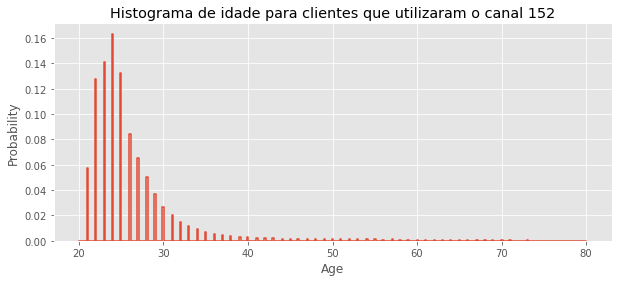

In [110]:
plt.figure(figsize=(10,4))
sns.histplot(x='Age', data=df_.query('Policy_Sales_Channel==152'), stat='probability',
            element='step', fill=False)
plt.title('Histograma de idade para clientes que utilizaram o canal 152');

### 11) O tempo como cliente influencia no interesse no seguro? Clientes mais antigos possuem maior interesse?

Nota-se pela distribuição abaixo que a variável apresenta uma distribuição uniforme, não havendo diferenciação substancial entre clientes há mais ou menos tempo, como pode-se observar pelo teste estatístico ponto-bisserial abaixo.

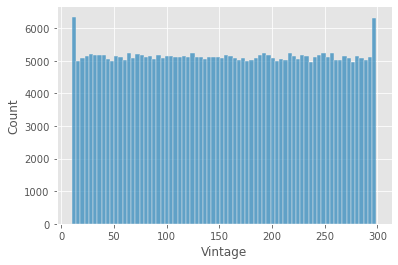

In [110]:
# histograma
sns.histplot(df_['Vintage']);

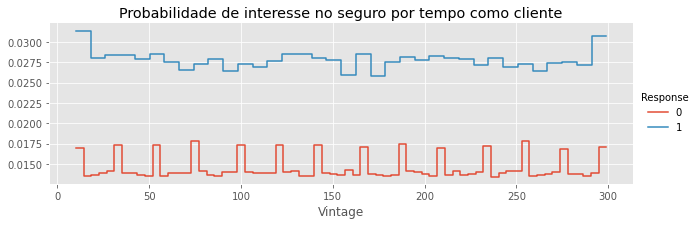

In [111]:
# histograma
sns.FacetGrid(hue='Response', data=df_, height=3, aspect=3,
             ).map_dataframe(sns.histplot, 'Vintage',
                             stat='probability', element='step', fill=False).add_legend()
plt.title('Probabilidade de interesse no seguro por tempo como cliente');

Utilizando o teste de associação point biserial entre as variáveis, notamos pelo resultado uma correlação negativa fraca de 0.001, ou seja, quando existe interesse no seguro auto, a tendência é que o cliente seja cliente da seguradora a menos tempo.

Nota-se, também, pelo resultado do p-value que a associação entre as variáveis que a associação não é estatisticamente significante, pois p-value > 5%.

In [112]:
# associação
corr,p_value = pb(df_['Response'], df_['Vintage'])
corr,p_value

(-0.0016310494486154827, 0.32062067441453485)

### - Sumarização:
___
- A taxa de interesse nos seguro foi de apenas 12% dentre o total de clientes
- Os clientes interessados apresentam idade entre 30 e 60 anos  
- Dentre os clientes mais jovens (< 30 anos), o veículo possui idade inferio a 1 ano (carro novo), sendo que entre 30-40 anos a probabilidade é de que o carro tenha entre 1 e 2 anos, e para clientes mais velhos (> 40 anos), a probabilidade é que o carro seja mais velho (> 2 anos)
- Dentre os poucos clientes sem habilitação e com interesse no seguro, todos são clientes mais velhos (> 44 anos), sendo que entre 50-65 anos a probabilidade é mais alta de que seja mulher, e acima de 65 anos, de que seja homem
- App. 27% da clientela se encontra na Região 28, com taxa de interesse de 41.4%, com perfil de idade mais com clientes mais velhos (maior propensão a interesse no seguro)
- Dentre os clientes previamente assegurados,  99.9% não apresentaram interesse em continuar com o seguro auto (churn), sendo que destes, 94.4% não tiveram seu veículo danificado
- A maioria dos clientes com interesse possuem veículo com idade entre 1 e 2 anos, sendo possível segmentá-los por idade dos clientes, como comentado acima
- Dentre os clientes que apresentaram interesse, 97.8% tiveram seu carro danificado
- O prêmio pago pelos clientes não foi capaz de segmentar significativamente os clientes com e sem interesse no seguro
- 60% dos clientes com interesse utilizaram os canais de venda 26 e 124. Considerando o canal 152, utilizado por 35.6% dos clientes, os quais foram em sua maioria jovens (< 30), com menor probabilidade de interesse no seguro
- O tempo como cliente da seguradora não foi uma variável de grande segmentação de interesse no seguro

### - Plano de Retenção de Clientes
___

A taxa de retenção de clientes da seguradora está extremamente baixa e, portanto, um plano de retenção de clientes deve ser elaborado baseando-se nos insights conseguidos através da EDA:

- Maior campanha marketing para os clientes entre 30 e 60 anos, principais clientes da seguradora
- Automatização dos canais de vendas, principalmente àqueles voltados aos jovens, visando ampliar a retenção deste grupo e.g. chatbot
- Up-selling e cross-selling de acordo com as necessidades do clientes (e.g. adicionar membro da família no seguro), bem como segmentação mais precisa do seguro pela idade do veículo
- Maior campanha de marketing na região 28, onde se encontram a maioria dos clientes
- Estudo de redução do prêmio para clientes que não tiveram seu veículo danificado, visando retenção dos clientes que apresentaram evasão

# Engenharia de Atributos
___

## - Importância dos atributos
___

Dentre as variáveis independentes, as que apresentaram maior associação/correlação com a variável responsta `Response` foram:

- `Age`
- `Previously_Insured`
- `Vehicle_Age`
- `Vehicle_Damage`
- `Policy_Sales_Channel`

Importante observar que algumas variáveis apresentaram associação fraca (0.1 < associação < 0.3), mas ainda assim foram consideradas para o modelo de aprendizado de máquina.

## - Seleção dos atributos
___

A seleção dos atributos foi realizada baseando-se na importância dos atributos mencionada acima.

In [114]:
dataset = df_[['Age','Previously_Insured','Vehicle_Age',
              'Vehicle_Damage','Policy_Sales_Channel','Response']]

In [115]:
dataset.head()

,Age,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Response
id,,,,,,
1,44,0,2,1,26.0,1
2,76,0,1,0,26.0,0
3,47,0,2,1,26.0,1
4,21,1,0,0,152.0,0
5,29,1,0,0,152.0,0


# Salvar dataset para modelagem
____

In [117]:
dataset.to_csv('train_pp.csv', index=True, header=True)